<a href="https://colab.research.google.com/github/Ahmed-Wassel-Angar/Project-2/blob/main/Project_2_Car_Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CONTEXT:**

- **Stakeholders:** An insurance car company.
- **Context:** The company shared its annual car insurance data and intend comprehend customer behaviors.
- **Dataset:**
  - The dataset has 19 features from there 18 of them are corresponding logs which were taken by the company.
  - The outcome column indicates whether a customer has claimed(1) his loan else (0).
- **Data Dictionary:** ID/ AGE/ GENDER/ RACE/ DRIVING EXPERIENCE/ EDUCATION/ INCOME/ CREDIT SCORE/ VEHICULE OWNERSHIP/ VEHICULE YEAR/ MARRIED/ CHILDREN/ POSTAL CODE/ ANNUAL MILEAGE/ VEHICULE TYPE/ SPEEDING VIOLATIONS/ DUIS/ PAST ACCIDENTS/ OUTCOME.
- **Data Souce:** Public dataset from Kaggle with real observations.


  

# **Instantiating Customized Functions**

In [37]:
#@title **Overview Data**

def overview(dataset):
  from google.colab import data_table
  data_table.enable_dataframe_formatter()

  df=dataset.copy()
  header="-"*25

  print(2*header,"START - OVERVIEW DATA",2*header)
  display(df)

  print(4*header, f"Dataset Statistics:", 4*header, sep='\n')

  num_cols = df.select_dtypes('number').columns
  cat_cols = df.select_dtypes('object').columns
  nbr_num_cols = len(num_cols)
  nbr_cat_cols = len(cat_cols)
  nbr_duplicated = df.duplicated().sum()
  nbr_missing = df.isna().sum().sum()
  nbr_obsol_rows = df.shape[0]-len(df.dropna(how='all'))
  nbr_obsol_columns = df.shape[1]-len(df.dropna(how='all',axis=1).columns)

  overview=pd.Series(index=["Number of variables:","Number of observations:","Duplicated rows:","Obsolete rows(empty rows):","Obsolete variables(empty columns):","Total Missing Values:"],
                     data=[f"{df.shape[1]} ({nbr_num_cols} numeric and {nbr_cat_cols} categorical)",
                           f"{df.shape[0]}",
                           f"{nbr_duplicated} ({nbr_duplicated/df.shape[0] *100:,.2f}%)",
                           f"{nbr_obsol_rows} ({nbr_obsol_rows/df.shape[0] *100:,.2f}%)",
                           f"{nbr_obsol_columns} ({nbr_obsol_columns/df.shape[1] *100:,.2f}%)",
                           f"{nbr_missing} ({nbr_missing/df.shape[0] *100:,.2f}%)"])
  print(overview.to_string())

  print(4*header, f"Numeric features: {nbr_num_cols} columns", sep='\n')
  print(num_cols.values)

  print(4*header, f"Categorical features: {nbr_cat_cols} columns", sep='\n')
  print(cat_cols.values)

  print(4*header, f"Missing Values per feature:", sep='\n')
  frame={'Counts':len(df)-df.isna().sum(),
         'Missing values':df.isna().sum(),
         'Percentage':df.isna().sum()/df.shape[0] *100}
  missing_values_counts = pd.DataFrame(frame)
  missing_values_counts.loc[:,"Percentage"]=missing_values_counts["Percentage"].map('{:,.2f} %'.format)
  #display(missing_values_counts.style)
  print(missing_values_counts)
  fig = plt.figure(figsize=(20,15))
  axes1 = fig.add_subplot(2,2,1)
  msno.bar(df,ax=axes1,color='blue',fontsize=12)
  axes1.tick_params(axis='x',rotation=90)
  axes2 = fig.add_subplot(2,2,2)
  msno.matrix(df,ax=axes2,sort='descending',fontsize=12)
  axes2.tick_params(axis='x',rotation=90)
  axes3 = fig.add_subplot(2,2,3)
  msno.heatmap(df,ax=axes3,fontsize=12)
  axes3.tick_params(axis='x',rotation=90)
  axes4= fig.add_subplot(2,2,4)
  msno.dendrogram(df,ax=axes4,fontsize=12,orientation='top')
  axes4.tick_params(axis='x',rotation=90)
  plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
  plt.show()

  data_table.disable_dataframe_formatter()

  print(2*header,"END - OVERVIEW DATA",2*header)


In [55]:
#@title **Explore Numerical Univariations**
def numerical_univariations(df,columns=None,iqr_coef=1.5,imb_threshold=0.1,out_threshold=0.05):
  """Explores numeric columns within a dataset.

  Parameters
  ----------
  df : Dataframe
      The dataset to be explored.
  columns : iterable, optional
      The array of the numeric columns' names(str) to include. if None, all numeric columns will be included.
  target : str, optional
      The target column's name. if None, dependency exploration vs the numeric columns won't be included.
  iqr_coef : float, defaul = 1.5
      The interquantile coefficient included in the detection of outliers. 'Q1'(or'Q3') - (or '+')iqr_coef*IQR
  imb_threshold : float, default = 0.1
      Threshold past it a category is imbalanced. exples: a column with 3 distinct values and an imb_threshold=0.2 is imbalanced when any of its values's imb_threshold>0.4((1+0.2)*1/3))
  out_threshold : float, default = 0.05
      the percentage(out_threshold*100) of the number of outliers (outside the IQR range) above which a warning is displayed.
  corr_threshold : float, default = 0.3
      The level of abs(correlation) above which two columns will be considered correlated. When correlated, a warning and the corressponding regplot will be displayed.

  Returns
  -------
  - Numeric columns considered in the exploration.
  - Nulls for each columns.
  - Total number of distinct values for each column, and top ten values.
  - Descriptive statistics for each column.
  - Quantile statistics for each coulmn.
  - Value counts for each column.
  - The distribution and the boxplot for each colum.
  - Alerts detected for each column (including symetry, skewness, outliers, cardinality, imbalance and constancy)
"""
  from sklearn.feature_selection import VarianceThreshold
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns
  import math

  if columns is None:
    num_cols = df.select_dtypes('number').columns
  else:
    num_cols = df[columns].select_dtypes('number').columns

  sns.set_style("whitegrid")
  sns.set(font_scale=0.8)
  header="-"*25


  vr = VarianceThreshold(threshold = 0.01)
  num_cols = df.select_dtypes('number').columns
  x=df[num_cols].dropna(how='any',axis=0)
  vr = VarianceThreshold(threshold = 0.02) # only columns with more than 2% variance are retained
  vr.fit(x)
  vr_filter = x.columns[~vr.get_support()] # List of columns with less than 2% variance
  print(2*header,"START - EXPLORE NUMERIC",2*header)
  print(" "*80,sep="\n")
  print(f"Numeric features: {len(num_cols)} columns",sep="\n")
  print(f"- List of columns: {num_cols.values}  ",sep="\n")
  print(f"- Columns with less than 2% variance: {vr_filter.values if len(vr_filter)!=0 else 'None'}  ",sep="\n")
  print(" "*80," "*80,sep="\n")
  statistics_frame=pd.DataFrame(columns=num_cols, index=['Mean','STD','Variance','Coef_of_Variance(CV)','Kurtosis(Unbiased)','Skewness','Medain Abs. Dev.(DAV)','Range','Outliers','Outliers(%)',\
                            'Minimum','5-th percentile','Q1','Median','Q3','95-th percentile','Maximum','IQR',"Lower Whisker","Upper whisker"])
  statistics_frame['Descriptive Statistics']=list(range(len(statistics_frame)))
  statistics_frame['Quantile Statistics']=list(range(len(statistics_frame)))
  All_val_counts=pd.DataFrame()
  alerts=pd.DataFrame(columns=['Feature','Alert'])

  index=0
  for col in num_cols:
    v= df[col]
    miss_val = v.isna().sum()
    miss_val_perc = round(miss_val/v.shape[0]*100,2)
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    iqr = q3 - q1
    out_v = v[(v <= q1 - 1.5 * iqr) | (v >= q3 + 1.5 * iqr)]
    outliers=out_v.shape[0]
    out_perc = round((outliers * 100 / df.shape[0]),2)
    statistics_frame.loc['Mean',col]=v.mean()
    statistics_frame.loc['STD',col]=v.std()
    statistics_frame.loc['Variance',col]=v.var()
    statistics_frame.loc['Coef_of_Variance(CV)',col]=v.std()/v.mean()
    statistics_frame.loc['Kurtosis(Unbiased)',col]=v.kurt(skipna=True)
    statistics_frame.loc['Skewness',col]=v.skew()
    statistics_frame.loc['Medain Abs. Dev.(DAV)',col]=v.mad()
    statistics_frame.loc['Range',col]=v.max()-v.mean()
    statistics_frame.loc['Outliers',col]=outliers
    statistics_frame.loc['Outliers(%)',col]=out_perc
    statistics_frame.loc['Minimum',col]=v.min()
    statistics_frame.loc['5-th percentile',col]=v.quantile(q=0.05)
    statistics_frame.loc['Q1',col]=q1
    statistics_frame.loc['Median',col]=v.quantile(q=0.5)
    statistics_frame.loc['Q3',col]=q3
    statistics_frame.loc['95-th percentile',col]=v.quantile(q=0.95)
    statistics_frame.loc['Maximum',col]=v.max()
    statistics_frame.loc['IQR',col]=iqr
    statistics_frame.loc['Lower Whisker',col]=q1-iqr_coef*iqr
    statistics_frame.loc['Upper whisker',col]=q3+iqr_coef*iqr

    val_counts=v.value_counts(dropna=False).sort_values(ascending=False)
    top_10_freq=val_counts if len(val_counts)<10 else val_counts.head(10)
    top_10_freq_perc = round(top_10_freq/v.shape[0]*100,3)
    val_counts_frame=pd.DataFrame({'Top 10 Values':top_10_freq.index.values,
                              'Counts':top_10_freq.values,
                              'Frequency(%)':top_10_freq_perc.values})
    if len(val_counts)>=10:
      val_counts_frame.loc[len(val_counts_frame.index)] = ['Other',val_counts.values.sum()-top_10_freq.values.sum(),round((val_counts.values.sum()-top_10_freq.values.sum())/val_counts.values.sum()*100,2)]
      alerts.loc[len(alerts.index)]=[col,f"- [!] Warning: High cardinality(nbr of classes >10) detected, {len(val_counts)} unique values detected!"]
    else:
      for i in range(len(val_counts)):
        if (val_counts.values[i]/val_counts.values.sum()) > (1+imb_threshold)/len(val_counts.values):
          alerts.loc[len(alerts.index)]=[col,f"- [!] Warning: Class imbalance detected!"]
          break
    alerts.loc[len(alerts.index)]=[col,f"- Most common value: '{val_counts.index[0]}' occurs {val_counts.values[0]} times ({round(val_counts.values[0] / len(df) * 100,2)}%)"]
    if val_counts.values[0] / len(df) * 100 > 98:
      alerts.loc[len(alerts.index)]=[col,"[!] Warning: feature is a constant or quasi-constant feature and should be dropped."]
    else:
      alerts.loc[len(alerts.index)]=[col,"- Not constant or quasi-constant(threshold at 98%)."]
    if out_perc >= round(out_threshold*100,2):
      alerts.loc[len(alerts.index)]=[col,f"- [!] Warning: Number of outliers exceeded the threshold of {round(out_threshold*100,2)}% ."]
    else:
      alerts.loc[len(alerts.index)]=[col,f"- No outliers detected above the level of {round(out_threshold*100,2)}%"]
    if v.is_unique:
      alerts.loc[len(alerts.index)]=[col,f"- [!] Warning: '{col}' has unique values."]
    All_val_counts=pd.concat([All_val_counts,pd.concat({col:val_counts_frame},axis=1)],axis=1)
    All_val_counts=All_val_counts.fillna('')

    gridspec={'height_ratios':[0.7,0.3]}
    fig, axes = plt.subplots(nrows=2,figsize=(7,4),sharex=True,gridspec_kw=gridspec)
    axes=axes.flatten()
    sns.histplot(df[col],ax=axes[0],kde=True,alpha=0.6,palette='Purples')
    sns.despine(top=True, right=True, bottom=True, left=True)
    axes[0].axvline(v.mean(),color='red', ls='--',label=f"Mean Value = {v.mean():,.2f}")
    axes[0].axvline(v.median(),color='black', ls='--',label=f"Median Value = {v.median():,.2f}",)
    axes[0].legend(bbox_to_anchor=(1,0),ncol=2,fontsize=10)
    fig.suptitle(f"Distribtion of {col}",y=1)
    axes[0].set_ylabel(f"Counts for {col}")
    axes[0].set_xlabel("")
    sns.boxplot(data=df,x=col,ax=axes[1],showmeans=True,whis=iqr_coef,width=0.5,saturation=0.75,fliersize=2,linewidth=1,meanprops={'marker':'o','markerfacecolor':'red','markeredgecolor':'black','markersize':'4'},palette="Purples")
    axes[1].set_xlabel("")
    sns.despine(ax=axes[1],top=True, right=True, bottom=False, left=True)
    plt.tick_params(axis='both',grid_alpha=0.5)
    plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=0.5)



  statistics_frame.iloc[0:10,statistics_frame.columns.get_indexer(['Descriptive Statistics'])]=1
  statistics_frame.iloc[10:20,statistics_frame.columns.get_indexer(['Descriptive Statistics'])]=0
  statistics_frame.iloc[0:10,statistics_frame.columns.get_indexer(['Quantile Statistics'])]=0
  statistics_frame.iloc[10:20,statistics_frame.columns.get_indexer(['Quantile Statistics'])]=1


  descriptive=statistics_frame.loc[statistics_frame['Descriptive Statistics']==1]
  quantile=statistics_frame.loc[statistics_frame['Quantile Statistics']==1]
  print(header*3,"Descriptive Statistics:",header*3,descriptive.T.to_string(),""*2,sep='\n')
  print(header*3,"Quantile Statistics:",header*3,quantile.T.to_string(),""*2,sep='\n')
  print(header*3,"Value Counts:",header*3,All_val_counts.T.to_string(),""*2,sep='\n')
  print(header*3,"Detected Alerts:",header*3,alerts.to_string(),""*2,sep='\n')
  print(header*3,"Distributions of features:",header*3,""*2,sep='\n')
  plt.show()
  del All_val_counts
  del alerts
  del statistics_frame

In [58]:
#@title **Explore Numeric Correlations**
def numeric_correlations(df,columns=None,target=None,corr_threshold=0.3):
  """Explores correlations of numeric columns within a dataset and against a categorical target if provided.

  Parameters
  ----------
  df : Dataframe
      The dataset to be explored.
  columns : iterable, optional
      The array of the numeric columns' names(str) to include. if None, all numeric columns will be included.
  target : str, optional
      The target column's name. if None, dependency exploration vs the numeric columns won't be included.
  corr_threshold : float, default = 0.3
      The level of abs(correlation) above which two columns will be considered correlated. When correlated, a warning and the corressponding regplot will be displayed.

  Returns
  -------
  - Correlation matrix.
  - Correlated columns.
  - Regplots for correlated columns.
  - Distributions and Boxplots of each numeric column per target's categories, if the provided target is categorical.
  """


  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns
  import missingno as msno
  import math

  sns.set_style("whitegrid")
  sns.set(font_scale=0.9)
  header="-"*25

  if columns is None:
    num_cols = df.select_dtypes('number').columns
  else:
    num_cols = num_cols = pd.Index(columns)

  print(2*header,"START - EXPLORE NUMERICAL CORRELATIONS",2*header)
  print(f"Numeric features: {len(num_cols)} columns",sep="\n")
  print(f"- List of columns: {num_cols.values}  ",sep="\n")

  if len(num_cols)>1:
    rows, cols = df[num_cols].shape
    features=list(df[num_cols].columns)
    corr_matrix = df[num_cols].corr()
    corr=corr_matrix.values
    fig, axes=plt.subplots(figsize=(10,5)) # creating figure and axes
    fig.suptitle("Matrix of Correlation") # figure title
    sns.heatmap(corr_matrix,cmap=sns.diverging_palette(240, 10, n=9),annot=True,annot_kws={'size':10},linewidths=0.75,linecolor="white",fmt=".2f")
    fig.autofmt_xdate(rotation=90) # rotating all axes within the figure
    plt.show()
    print(4*header,f"Correlations higher than corr_threshold= {corr_threshold}:" ,sep="\n")
    i_rows=[]
    j_cols=[]
    correlations=pd.DataFrame({'Correlated features':[],
                               'Correlation':[]})
    for i in range(cols):
      for j in range(i+1,cols):
        if abs(corr[i,j])>=corr_threshold:
          i_rows.append(i)
          j_cols.append(j)
          #print(f"- [!] Warning: '{features[i]}' is correlated to '{features[j]}' at a level of corr={round(corr[i,j],2)}")
          correlations.loc[len(correlations.index)]=[f"'{features[i]}' vs. '{features[j]}'",round(corr[i,j],3)]
    print(correlations.sort_values(by='Correlation',ascending=False).to_string(index=False))


    fig, axes = plt.subplots(nrows=math.ceil((len(i_rows)+1)/2), ncols=2 ,figsize=(2*5 if len(j_cols)>2 else 15*len(j_cols),5*math.ceil((len(i_rows)+1)/2)))
    dim=math.ceil(len(i_rows)/2) * 2
    print(dim,i_rows,j_cols)
    if dim>1:
      axes=axes.flatten()

    sns.despine(top=True, right=True, bottom=False, left=False)
    for index in range(len(i_rows)):
      sns.regplot(data=df[num_cols],x=features[i_rows[index]],y=features[j_cols[index]],ax=axes[index] if dim>1 else axes,scatter_kws={'ec':'white','lw':0.5,'alpha':0.8})

    for ax in axes:
      if not ax.has_data():
        fig.delaxes(ax)

    plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
    print(4*header,f"Regression plots for correlations higher than corr_threshold= {corr_threshold}:" ,sep="\n")
    plt.show()

    print(4*header,f"Distributions of numeric columns per target's categories:" ,sep="\n")
    if target == None:
      print("- [!] Warning: no submitted target!",4*header,sep='\n')
    elif (df[target].dtypes=='int') | (df[target].dtypes=='float'):
      print(f"- [!] Warning: target '{target}' passed is numeric, this section executes only for categorical targets!",4*header,sep='\n')
    else:
      n_classes=df[target].nunique()
      fig, axes = plt.subplots(nrows=math.ceil(len(num_cols)),ncols=3,figsize=(15,5*math.ceil(len(num_cols))))
      dim=math.ceil(n_classes/3)*3
      if dim>1:
        axes=axes.flatten()
      sns.despine(top=True, right=True, bottom=False, left=False)
      index=0
      for col in num_cols:
        sns.kdeplot(df,x=col,hue=target,ax=axes[index],fill=True)
        sns.boxplot(df,x=col,y=target,hue=target,ax=axes[index+1])
        sns.barplot(df,x=col,y=target,ax=axes[index+2], alpha=0.6, linewidth=1, edgecolor='black', errorbar=None)
        sns.stripplot(data=df,x=col,y=target,hue=target,ax=axes[index+2],legend=False,edgecolor='white', linewidth=0.5, size=3,zorder=0)
        index=index+3
      for ax in axes:
        if not ax.has_data():
          fig.delaxes(ax)
      plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
      plt.show()

  print(2*header,"END - EXPLORE NUMERIC CORRELATIONS",2*header)



In [40]:
#@title **Explore Categorical Univariations**
def categorical_univariations(df,columns=None,imb_threshold=0.1):

  if columns is None:
    cat_cols = df.select_dtypes('object').columns
  else:
    cat_cols = pd.Index(columns)
  sns.set_style("whitegrid")
  sns.set(font_scale=0.8)
  header="-"*25

  print(2*header,"START - EXPLORE CATEGORICAL",2*header)
  print(" "*80,sep="\n")
  print(f"Categorical features: {len(cat_cols)} columns",sep="\n")
  print(f"List of columns: {cat_cols.values}  ",sep="\n")
  print(" "*80," "*80,sep="\n")

  for col in cat_cols:
    v= df[col]
    miss_val = v.isna().sum()
    miss_val_perc = round(miss_val/v.shape[0]*100,2) #or miss_val_perc = v.isna().mean()*100

    val_counts=v.value_counts(dropna=False).sort_values(ascending=False)
    top_10_freq=val_counts if len(val_counts)<10 else val_counts.head(10)
    top_10_freq_perc = round(top_10_freq/v.shape[0]*100,3)
    val_counts_frame=pd.DataFrame({'Top 10 Values':top_10_freq.index.values,
                            'Counts':top_10_freq.values,
                            'Frequency(%)':top_10_freq_perc.values})
    if len(val_counts)>=10:
      val_counts_frame.loc[len(val_counts_frame.index)] = ['Other',val_counts.values.sum()-top_10_freq.values.sum(),round((val_counts.values.sum()-top_10_freq.values.sum())/val_counts.values.sum()*100,2)]


    print(4*header,f"  {col}: catgorical column - Nulls: {miss_val}({miss_val_perc}%) - {v.dtypes} - {len(val_counts)} distinct values",4*header,sep="\n")
    print(val_counts_frame.to_string(index=False))
    print(" "*80,sep="\n")

    print(f"Alerts for feature '{col}':",sep="\n")
    val_counts_noNans=v.value_counts()
    values=val_counts_noNans.values
    if len(val_counts_noNans)>10:
      print(f"- [!] Warning: High cardinality(nbr of classes >10) detected within column {col}, {len(val_counts_noNans)} unique values detected!")
    else:
      for i in range(len(val_counts_noNans)):
        if (values[i]/values.sum()) > (1+imb_threshold)/len(values):
          print(f"- [!] Warning: Class imbalance detected within column '{col}'")
          break

    most_common_val = val_counts_noNans.index[0]
    freq = val_counts_noNans.values[0]
    perc_most_common = freq / len(df) * 100
    print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
    if perc_most_common > 98:
      print(f"- [!] Warning: '{col}' is a constant or quasi-constant feature and should be dropped.")
    else:
      print("- Not constant or quasi-constant(threshold at 98%).")

    if v.is_unique:
      print(f"- [!] Warning: '{col}' has unique values.")
    print(" "*80,sep="\n")

    gridspec={'width_ratios':[0.7,0.3]}
    fig, axes = plt.subplots(ncols=2,figsize=(12,4),gridspec_kw=gridspec)
    axes=axes.flatten()
    sns.despine(top=True, right=True, bottom=False, left=False)
    sns.countplot(data=df,ax=axes[0],x=col,
              linewidth=1, edgecolor='white',order=val_counts.index.values)
    # Rotate Tick Labels for long names
    axes[0].set_title(f"Counts of {col}")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[0].set_ylabel("")
    axes[0].set_xlabel("")
    #colors=sns.color_palette('Blues') if used add colors=colors to the pie plot
    #plt.pie(data=val_counts,x=val_counts.values,labels=val_counts.index.values, autopct='%.0f%%',colors=colors,labeldistance=1.4,pctdistance=1.2)
    plt.pie(data=val_counts,x=val_counts.values, autopct='%.0f%%',labeldistance=1.4,pctdistance=1.2)
    plt.legend(val_counts.index.values,loc="best",bbox_to_anchor=(1,1),ncols=1)
    plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=0.5)
    #print(4*header,f"Counts of '{col}':",sep="\n")
    plt.show()
    print(" "*80," "*80,sep="\n")


  print(2*header,"END - EXPLORE CATEGORICAL",2*header)


In [64]:
#@title **Explore Categorical Correlations**
def categorical_correlations(df,columns=None,target=None,significance_level=0.05,plot_contingency=False):
  from scipy.stats import chi2_contingency
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns
  import math

  if columns is None:
    cat_cols = df.select_dtypes('object').columns
  else:
    cat_cols = pd.Index(columns)

  sns.set_style("whitegrid")
  sns.set(font_scale=0.9)
  header="-"*25
  rows, cols = df[cat_cols].shape
  header='-'*30

  if plot_contingency==True:
    features=list(df[cat_cols].columns)
    dim=((cols**2)-cols)/2
    fig, axes = plt.subplots(nrows=math.ceil(dim/3),ncols=3,figsize=(20,5*math.ceil(dim/3)))
    if dim>1:
      axes=axes.flatten()
    sns.despine(top=True, right=True, bottom=True, left=True)


  p_value_frame=pd.DataFrame(index=cat_cols,columns=cat_cols)
  Cramer_V_frame=pd.DataFrame(index=cat_cols,columns=cat_cols)



  index=0
  for i in range(cols):
    for j in range(i,cols):
      if i==j:
        p_value=0
        Cramer_V=1
        p_value_frame.iloc[i,j]=Cramer_V
        p_value_frame.iloc[j,i]=Cramer_V
        Cramer_V_frame.iloc[i,j]=Cramer_V
        Cramer_V_frame.iloc[j,i]=Cramer_V
      else:
        crosstab=pd.crosstab(df[cat_cols].iloc[:,i],df[cat_cols].iloc[:,j])
        chi2, pval, dof, expected = chi2_contingency(crosstab,correction=False)
        N=crosstab.sum().sum()
        min_dimension = min(crosstab.shape)-1
        Cramer_V=np.sqrt((chi2/N) / min_dimension)
        p_value_frame.iloc[i,j]=pval
        p_value_frame.iloc[j,i]=pval
        Cramer_V_frame.iloc[i,j]=Cramer_V
        Cramer_V_frame.iloc[j,i]=Cramer_V
        if pval <= significance_level and plot_contingency==True:
          crosstab.plot(kind='bar',ax=axes[index])
          for c in axes[index].containers: # adding annotation to barplots
            axes[index].bar_label(c,label_type='edge',fontsize=9)
          axes[index].set_title(f"P-value= {round(pval,3)}, Cramer_V= {round(Cramer_V,3)}")
          axes[index].legend(bbox_to_anchor=(1,1),ncol=1,title=features[j],loc='best')
          index+=1
  if plot_contingency==True:
    for ax in axes:
      if not ax.has_data():
        fig.delaxes(ax)
    plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)

  p_value_frame = p_value_frame[p_value_frame.columns].astype(float) #change column's type(not data) to eliminate 'TypeError: Image data can not convert to float'
  Cramer_V_frame = Cramer_V_frame[Cramer_V_frame.columns].astype(float)#change column's type(not data) to eliminate 'TypeError: Image data can not convert to float'
  fig2, axes2=plt.subplots(ncols=2,figsize=(15,8)) # creating figure and axes
  sns.heatmap(p_value_frame,cmap="Blues_r",annot=True,annot_kws={'size':10},linewidths=0.75,linecolor="white",fmt=".2f",ax=axes2[0])
  axes2[0].set_title("Matrix of P-values")
  sns.heatmap(Cramer_V_frame,cmap=sns.diverging_palette(240, 10, n=9),annot=True,annot_kws={'size':10},linewidths=0.75,linecolor="white",fmt=".2f",ax=axes2[1])
  axes2[1].set_title("Matrix of Cramer's Vs")
  plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
  fig2.autofmt_xdate(rotation=90) # rotating all axes within the figure



  print(header,"- If (p-value <= sig_level) then Null hypothesis is rejected and correspondant features are associated at a level of Cramer's V!","-  Cramer's V varies between [0,1] inclusive.","-  [!] IMPORTANT: Only associated features are plotted" if plot_contingency else '',header,sep='\n')
  plt.show()
  print(4*header,f"Distributions of the target per columns' categories:" ,sep="\n")
  if target == None:
    pass
  elif df[target].dtypes=='object':
    print("- [!] Warning: target passed is categorical, this section executes only for numeric targets!",4*header,sep='\n')
  else:
    fig, axes = plt.subplots(nrows=math.ceil(len(cat_cols)),ncols=3,figsize=(15,5*math.ceil(len(cat_cols))))
    dim=math.ceil(len(cat_cols))*3
    if dim>1:
      axes=axes.flatten()
    sns.despine(top=True, right=True, bottom=False, left=False)
    index=0
    for col in cat_cols:
      sns.kdeplot(df,x=target,hue=col,ax=axes[index],fill=True)
      sns.boxplot(df,x=target,y=col,hue=col,ax=axes[index+1])
      sns.barplot(df,x=target,y=col,ax=axes[index+2], alpha=0.6, linewidth=1, edgecolor='black', errorbar=None)
      sns.stripplot(data=df,x=target,y=col,hue=col,ax=axes[index+2],legend=False,edgecolor='white', linewidth=0.5, size=3,zorder=0)
      index=index+3
    plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
    plt.show()

  print(2*header,"END - EXPLORE CATEGORICAL",2*header)


#**Loading Data:**

In [34]:
# Mount drive
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# Importing librairies
import pandas as pd
pd.set_option('display.max_columns',None)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math
from google.colab import data_table
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')


In [36]:
# Load Data
df= pd.read_csv("/content/drive/MyDrive/Coding Dojo/Project 2/Car_Insurance_Claim.csv")

#**EDA**

In [ ]:
# Global overview of the dataset
overview(df)

- the dataset has 10000 rows and 19(11 numeric and 8 categorical) columns. Each row represent a customer and its corresspondant informations.
- The dataset has no duplicated rows, no obsolete(empty) rows and no obsolete columns.
- The dataset has missing values within features `credit score`(9.82%) and `annual mileage`(9.57%). => We will treat missing values at the end of the EDA if necesseray otherwise during preprocessing for modeling.
- There is no obvious association of missingness between columns.

In [ ]:
# Lower case all columns'names for convenience
df.columns=map(str.lower, df.columns) # same as df.columns = [x.lower() for x in df.columns]
df.columns

Index(['id', 'age', 'gender', 'race', 'driving_experience', 'education',
       'income', 'credit_score', 'vehicle_ownership', 'vehicle_year',
       'married', 'children', 'postal_code', 'annual_mileage', 'vehicle_type',
       'speeding_violations', 'duis', 'past_accidents', 'outcome'],
      dtype='object')

-------------------------------------------------- START - EXPLORE NUMERIC --------------------------------------------------
                                                                                
Numeric features: 11 columns
- List of columns: ['ID' 'CREDIT_SCORE' 'VEHICLE_OWNERSHIP' 'MARRIED' 'CHILDREN'
 'POSTAL_CODE' 'ANNUAL_MILEAGE' 'SPEEDING_VIOLATIONS' 'DUIS'
 'PAST_ACCIDENTS' 'OUTCOME']  
- Columns with less than 2% variance: ['CREDIT_SCORE']  
                                                                                
                                                                                
---------------------------------------------------------------------------
Descriptive Statistics:
---------------------------------------------------------------------------
                                Mean            STD            Variance Coef_of_Variance(CV) Kurtosis(Unbiased)  Skewness Medain Abs. Dev.(DAV)         Range Outliers Outliers(%)
ID               

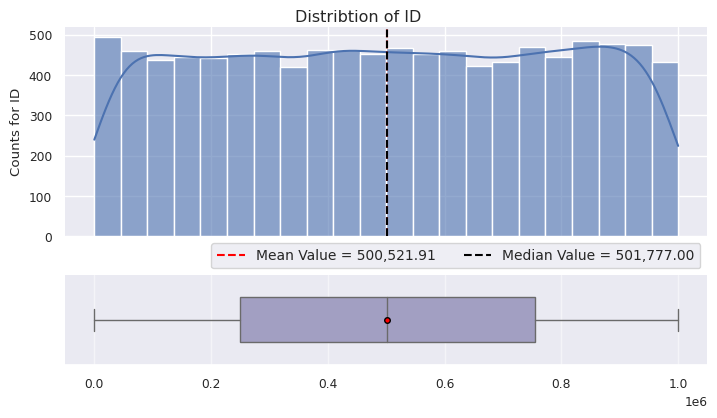

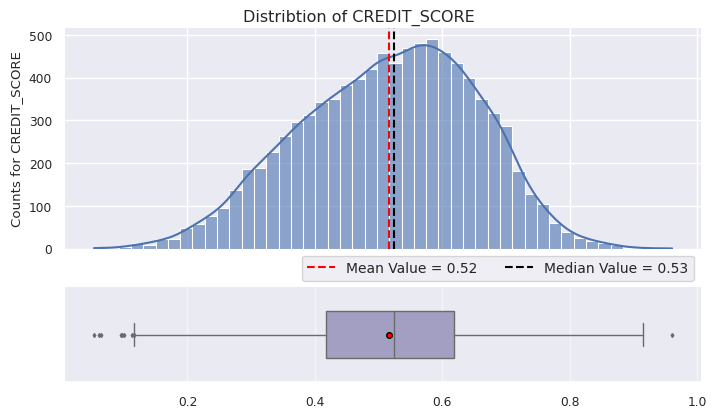

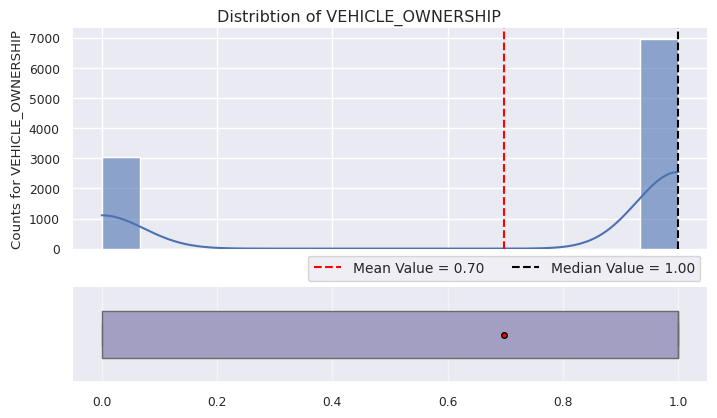

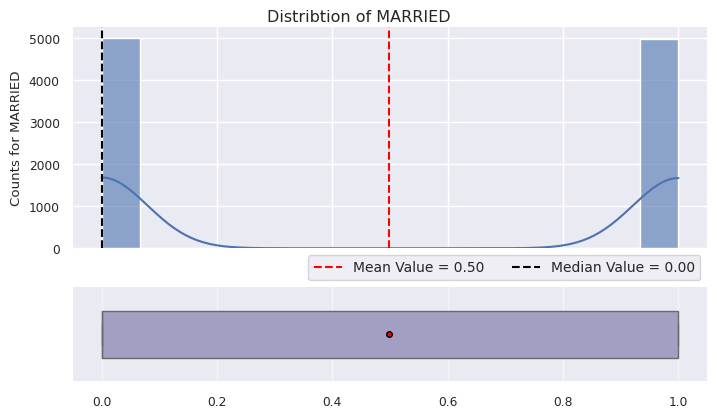

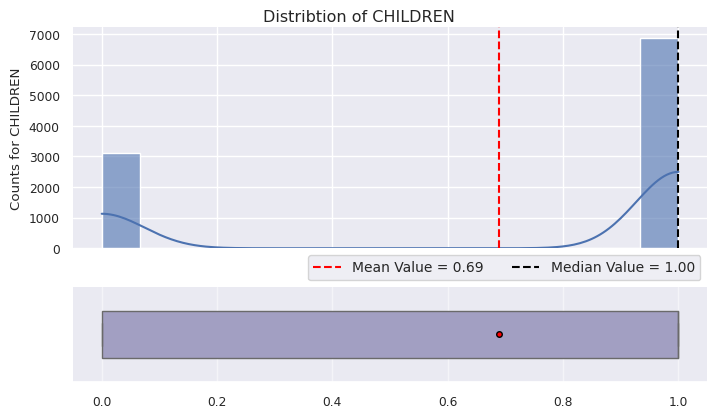

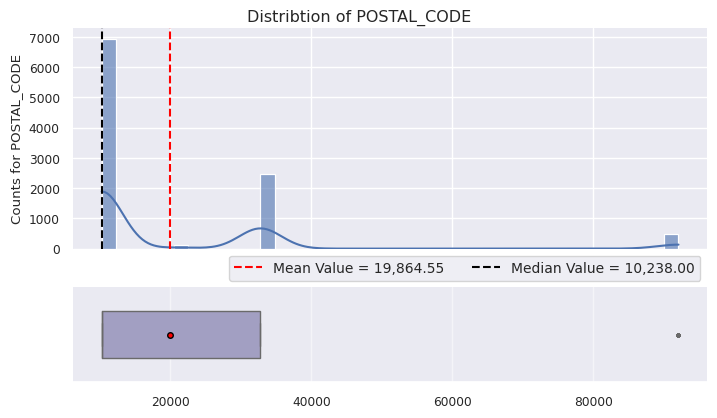

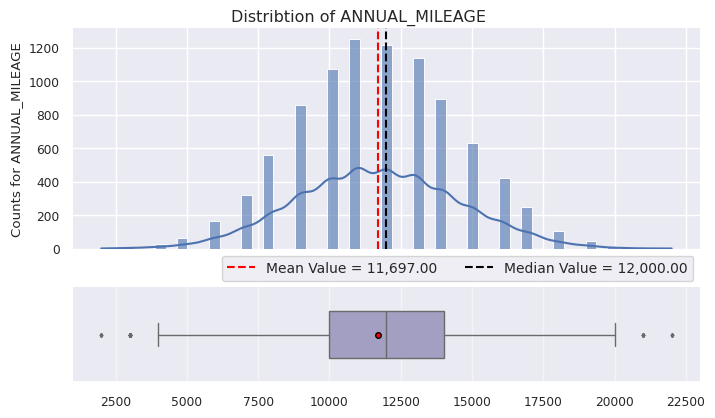

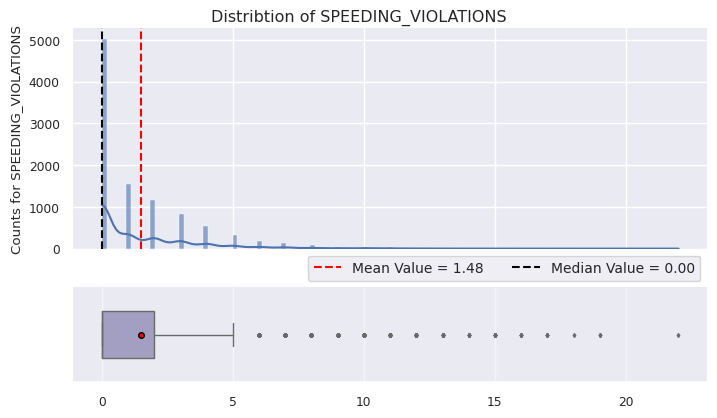

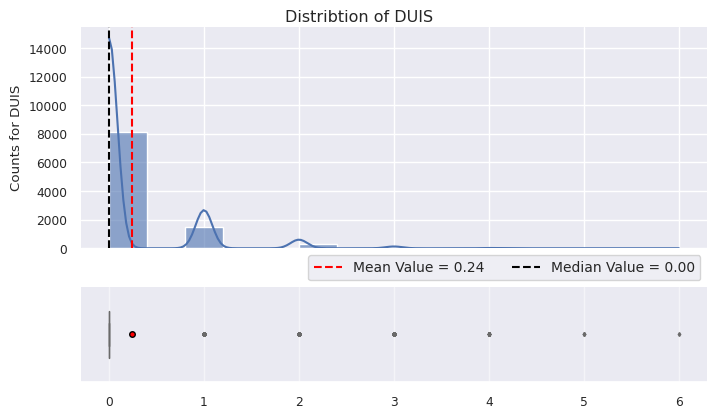

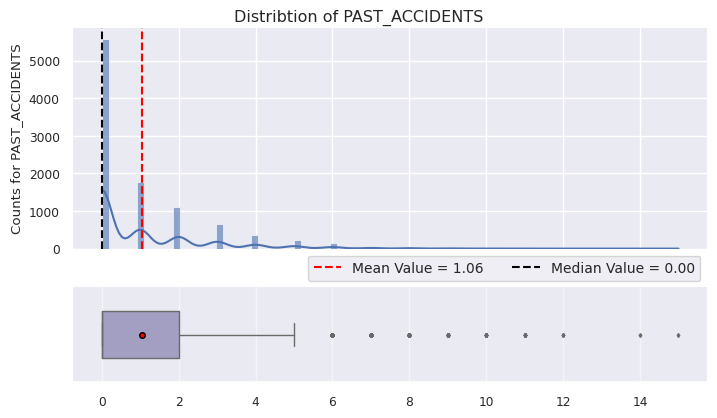

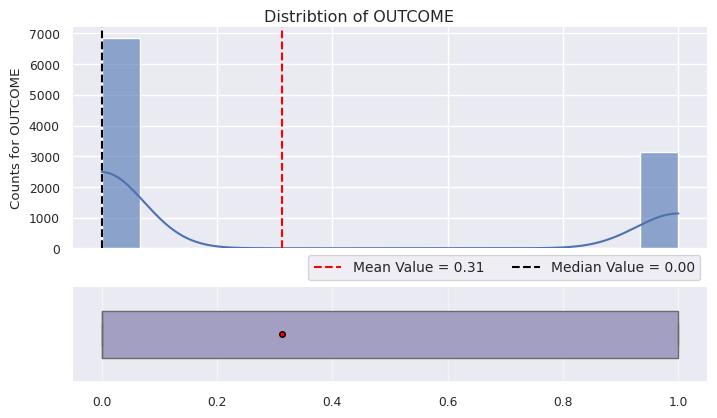

In [56]:
# Explore numeric columns
numerical_univariations(df)

Feature|Observations
-|-
ID|<li>is a unique column(10000 distinct values). => Will be dropped.
CREDIT_SCORE|<li>is normally ditributed and symetric with kurtosis(indicates fatness of tails) and skewness(indicates symetry around the mean) almost Zeros.
VEHICULE_OWNERSHIP|<li>must be a categorical column with 1 or 0 values.=>Type will be changed.
MARRIED|<li>must be a categorical column with 1 or 0 values.=>Type will be changed.
CHILDREN|<li>must be a categorical column with 1 or 0 values.=>Type will be changed.<li>class imbalance was detected.
POSTAL CODE|<li>must be a categorical column with 1 or 0 values.=>Type will be changed.<li>class imbalance was detected.
ANNUAL_MILEAGE|<li>is normally ditributed and symetric with kurtosis(indicates fatness of tails) and skewness(indicates symetry around the mean) almost Zeros.
SPEED_VIOLATIONS|<li>---
DUIS|<li>---
PAST-ACCIDENTS|<li>---
OUTCOME|<li>must be a categorical column with 1 or 0 values.=>Type will be changed.<li>Class imbalance detected.

-------------------------------------------------- START - EXPLORE NUMERICAL CORRELATIONS --------------------------------------------------
Numeric features: 11 columns
- List of columns: ['ID' 'CREDIT_SCORE' 'VEHICLE_OWNERSHIP' 'MARRIED' 'CHILDREN'
 'POSTAL_CODE' 'ANNUAL_MILEAGE' 'SPEEDING_VIOLATIONS' 'DUIS'
 'PAST_ACCIDENTS' 'OUTCOME']  


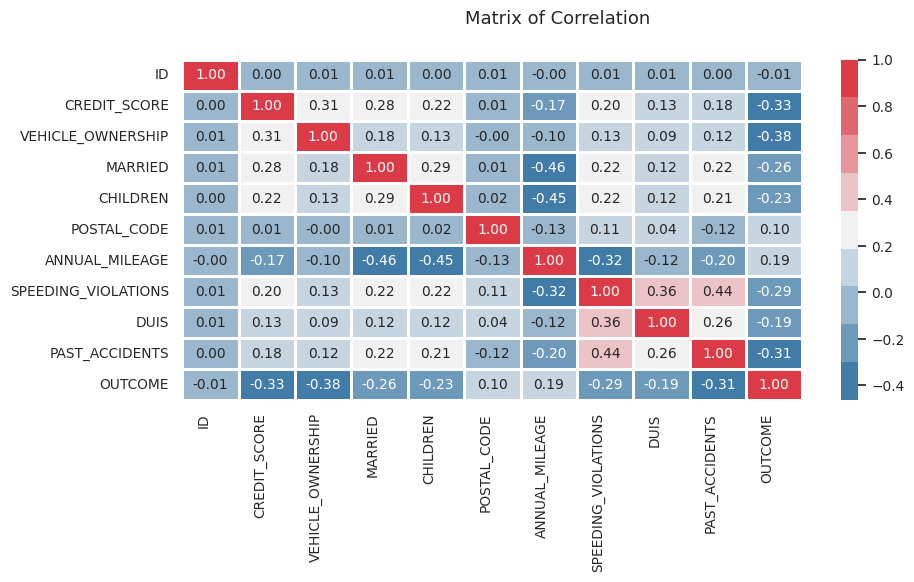

----------------------------------------------------------------------------------------------------
Correlations higher than corr_threshold= 0.3:
                       Correlated features  Correlation
'SPEEDING_VIOLATIONS' vs. 'PAST_ACCIDENTS'        0.443
          'SPEEDING_VIOLATIONS' vs. 'DUIS'        0.360
    'CREDIT_SCORE' vs. 'VEHICLE_OWNERSHIP'        0.312
            'PAST_ACCIDENTS' vs. 'OUTCOME'       -0.311
'ANNUAL_MILEAGE' vs. 'SPEEDING_VIOLATIONS'       -0.324
              'CREDIT_SCORE' vs. 'OUTCOME'       -0.325
         'VEHICLE_OWNERSHIP' vs. 'OUTCOME'       -0.379
           'CHILDREN' vs. 'ANNUAL_MILEAGE'       -0.448
            'MARRIED' vs. 'ANNUAL_MILEAGE'       -0.462
10 [1, 1, 2, 3, 4, 6, 7, 7, 9] [2, 10, 10, 6, 6, 7, 8, 9, 10]
----------------------------------------------------------------------------------------------------
Regression plots for correlations higher than corr_threshold= 0.3:


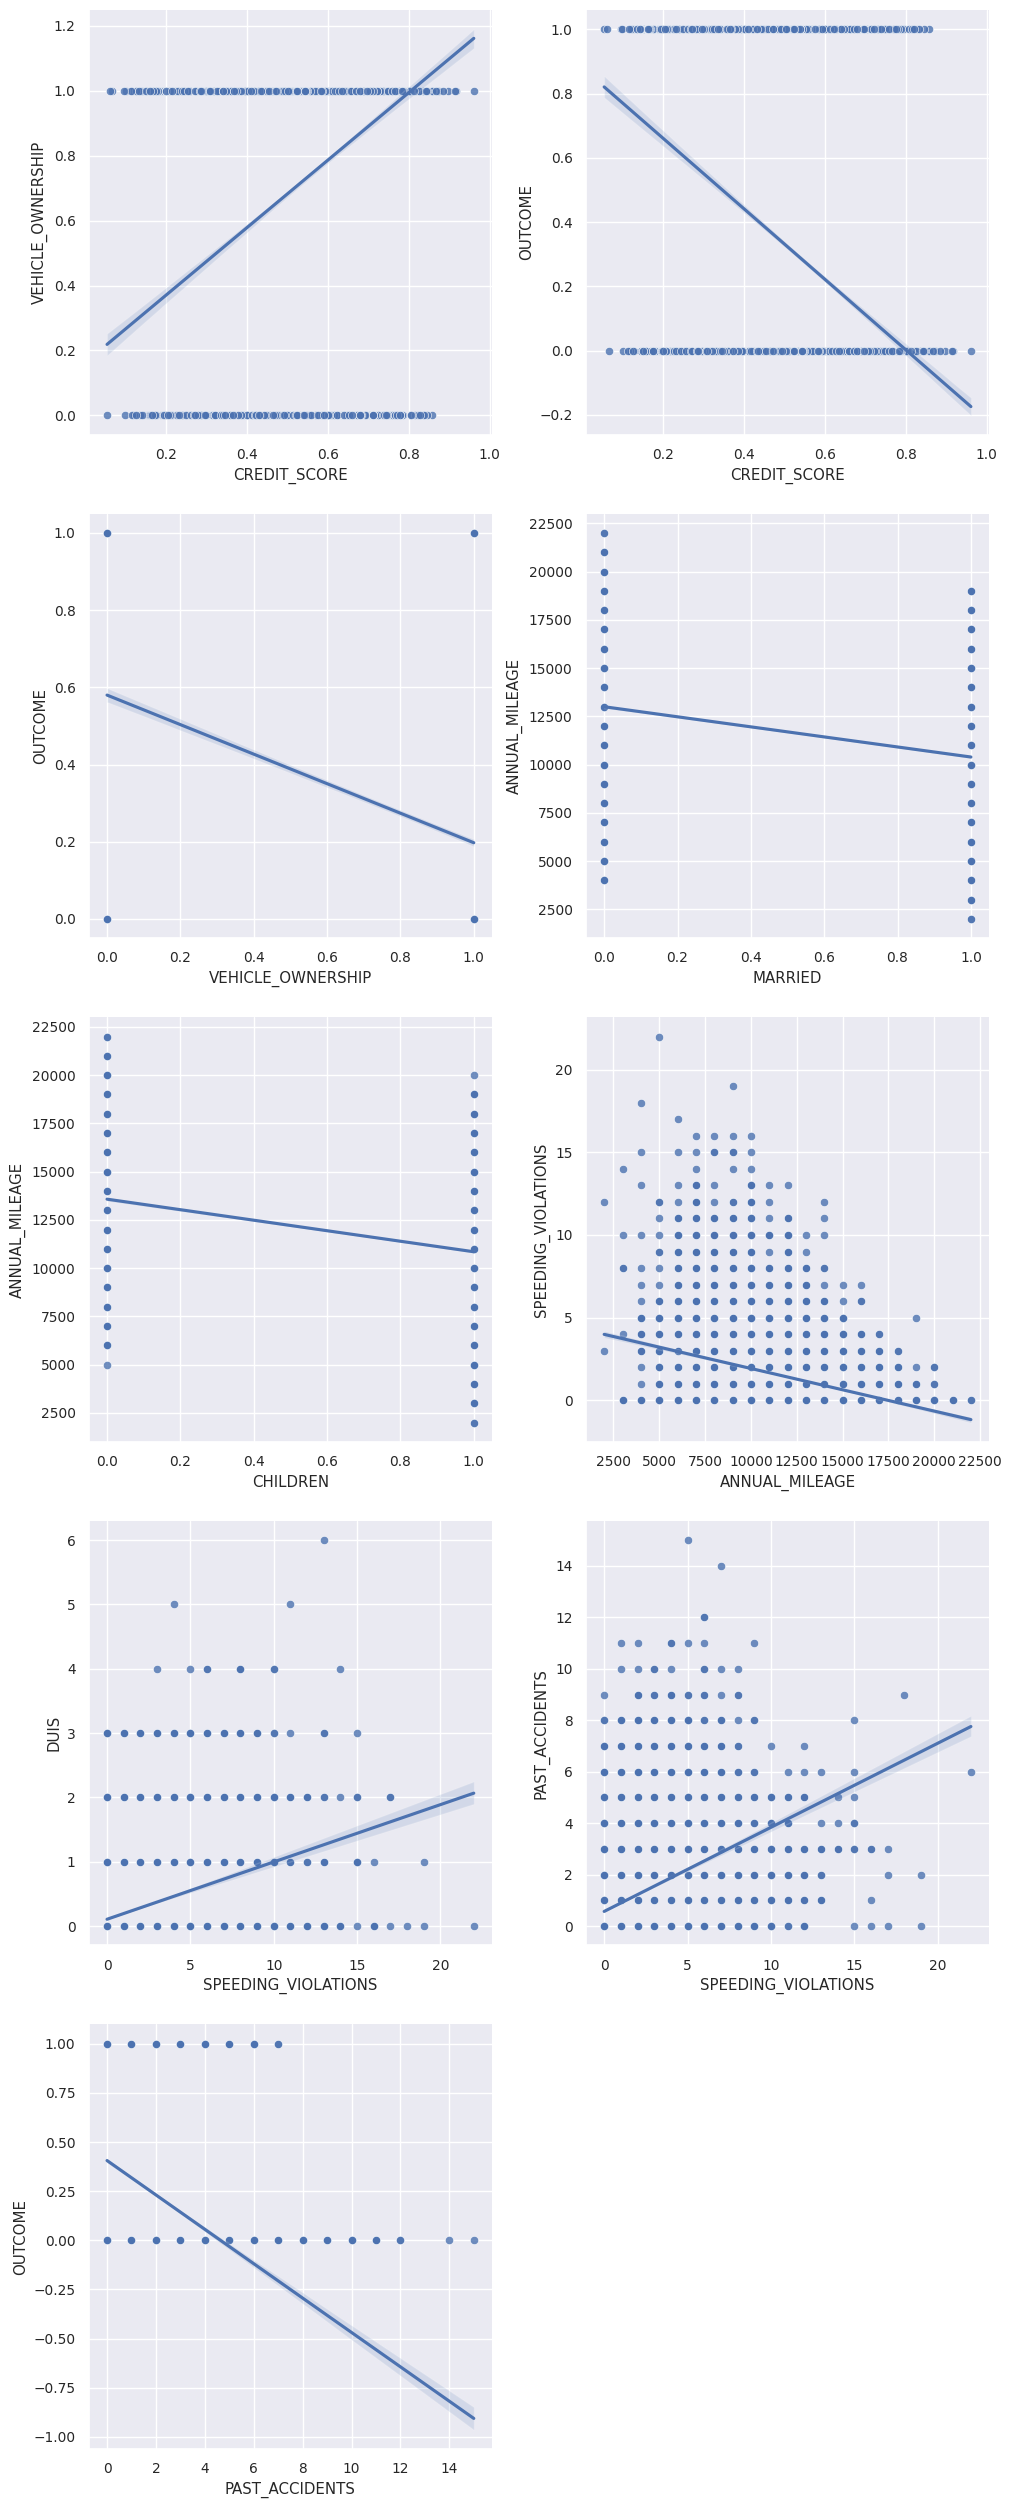

----------------------------------------------------------------------------------------------------
Distributions of numeric columns per target's categories:
- [!] Warning: no submitted target!
----------------------------------------------------------------------------------------------------
-------------------------------------------------- END - EXPLORE NUMERIC CORRELATIONS --------------------------------------------------


In [57]:
numeric_correlations(df)

In [60]:
# Lower case all columns'names for convenience
df.columns=map(str.lower, df.columns) # same as df.columns = [x.lower() for x in df.columns]
df.columns
# Dropping column 'id'
df=df.drop(columns=['id'])
# 'Inferring types of columns
df[['postal_code']]=df[['postal_code']].astype(str)
# Cheking types
df.dtypes

age                     object
gender                  object
race                    object
driving_experience      object
education               object
income                  object
credit_score           float64
vehicle_ownership      float64
vehicle_year            object
married                float64
children               float64
postal_code             object
annual_mileage         float64
vehicle_type            object
speeding_violations      int64
duis                     int64
past_accidents           int64
outcome                float64
dtype: object

-------------------------------------------------- START - EXPLORE CATEGORICAL --------------------------------------------------
                                                                                
Categorical features: 9 columns
List of columns: ['age' 'gender' 'race' 'driving_experience' 'education' 'income'
 'vehicle_year' 'postal_code' 'vehicle_type']  
                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  age: catgorical column - Nulls: 0(0.0%) - object - 4 distinct values
----------------------------------------------------------------------------------------------------
Top 10 Values  Counts  Frequency(%)
        26-39    3063         30.63
        40-64    2931         29.31
        16-25    2016         20.16
          65+    1990         19.90
            

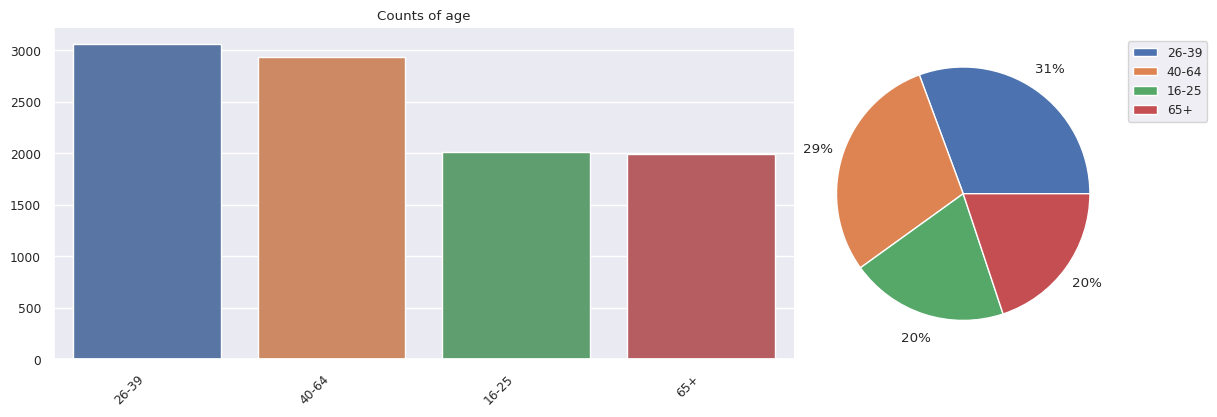

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  gender: catgorical column - Nulls: 0(0.0%) - object - 2 distinct values
----------------------------------------------------------------------------------------------------
Top 10 Values  Counts  Frequency(%)
       female    5010          50.1
         male    4990          49.9
                                                                                
Alerts for feature 'gender':
- Most common value: 'female' occurs 5010 times (50.1%)
- Not constant or quasi-constant(threshold at 98%).
                                                                                


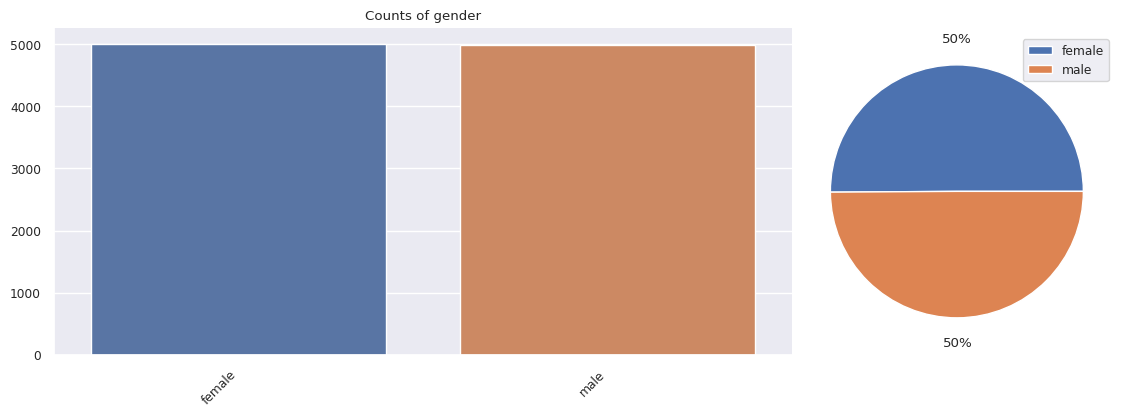

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  race: catgorical column - Nulls: 0(0.0%) - object - 2 distinct values
----------------------------------------------------------------------------------------------------
Top 10 Values  Counts  Frequency(%)
     majority    9012         90.12
     minority     988          9.88
                                                                                
Alerts for feature 'race':
- [!] Warning: Class imbalance detected within column 'race'
- Most common value: 'majority' occurs 9012 times (90.12%)
- Not constant or quasi-constant(threshold at 98%).
                                                                                


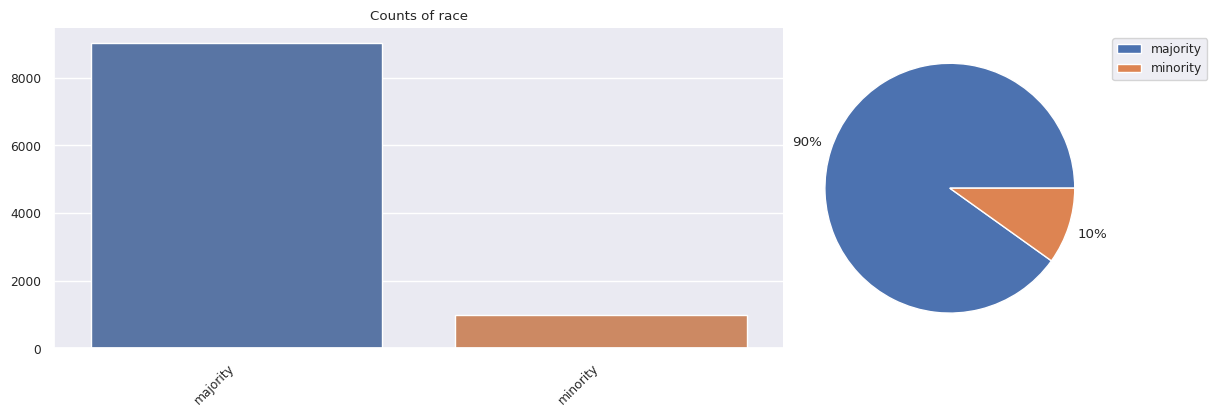

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  driving_experience: catgorical column - Nulls: 0(0.0%) - object - 4 distinct values
----------------------------------------------------------------------------------------------------
Top 10 Values  Counts  Frequency(%)
         0-9y    3530         35.30
       10-19y    3299         32.99
       20-29y    2119         21.19
         30y+    1052         10.52
                                                                                
Alerts for feature 'driving_experience':
- [!] Warning: Class imbalance detected within column 'driving_experience'
- Most common value: '0-9y' occurs 3530 times (35.3%)
- Not constant or quasi-constant(threshold at 98%).
                                                                   

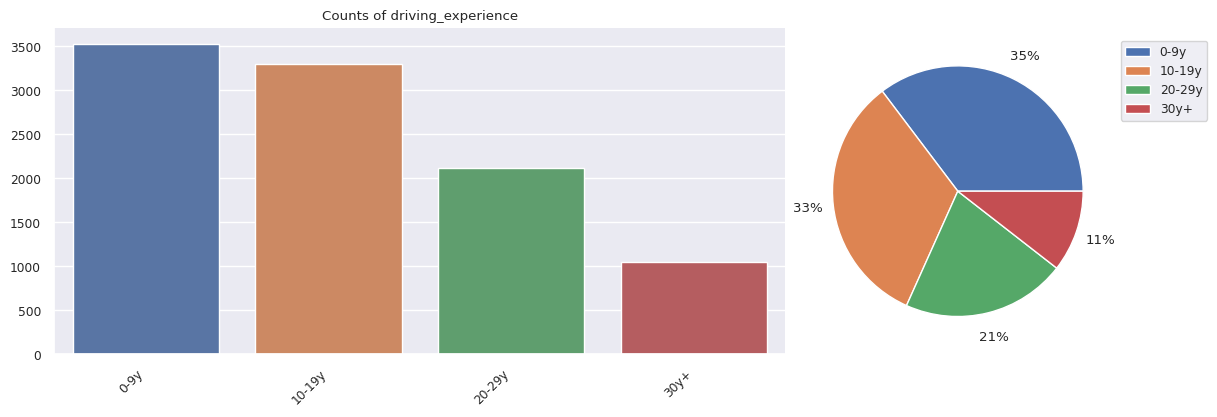

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  education: catgorical column - Nulls: 0(0.0%) - object - 3 distinct values
----------------------------------------------------------------------------------------------------
Top 10 Values  Counts  Frequency(%)
  high school    4157         41.57
   university    3928         39.28
         none    1915         19.15
                                                                                
Alerts for feature 'education':
- [!] Warning: Class imbalance detected within column 'education'
- Most common value: 'high school' occurs 4157 times (41.57%)
- Not constant or quasi-constant(threshold at 98%).
                                                                                


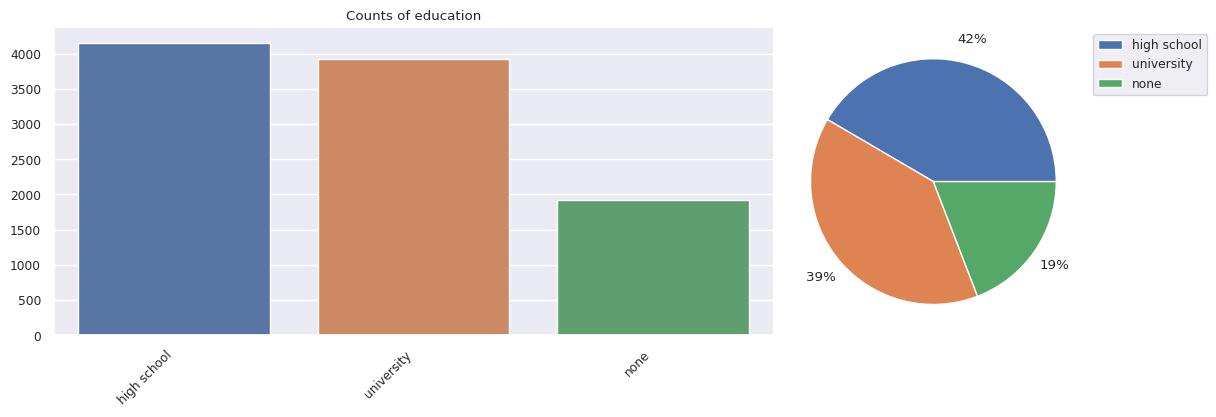

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  income: catgorical column - Nulls: 0(0.0%) - object - 4 distinct values
----------------------------------------------------------------------------------------------------
Top 10 Values  Counts  Frequency(%)
  upper class    4336         43.36
 middle class    2138         21.38
      poverty    1814         18.14
working class    1712         17.12
                                                                                
Alerts for feature 'income':
- [!] Warning: Class imbalance detected within column 'income'
- Most common value: 'upper class' occurs 4336 times (43.36%)
- Not constant or quasi-constant(threshold at 98%).
                                                                                


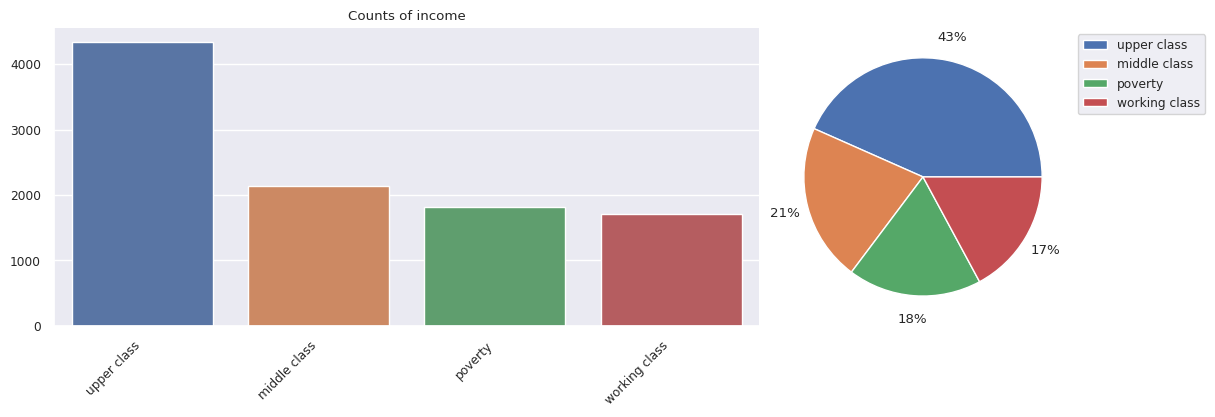

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  vehicle_year: catgorical column - Nulls: 0(0.0%) - object - 2 distinct values
----------------------------------------------------------------------------------------------------
Top 10 Values  Counts  Frequency(%)
  before 2015    6967         69.67
   after 2015    3033         30.33
                                                                                
Alerts for feature 'vehicle_year':
- [!] Warning: Class imbalance detected within column 'vehicle_year'
- Most common value: 'before 2015' occurs 6967 times (69.67%)
- Not constant or quasi-constant(threshold at 98%).
                                                                                


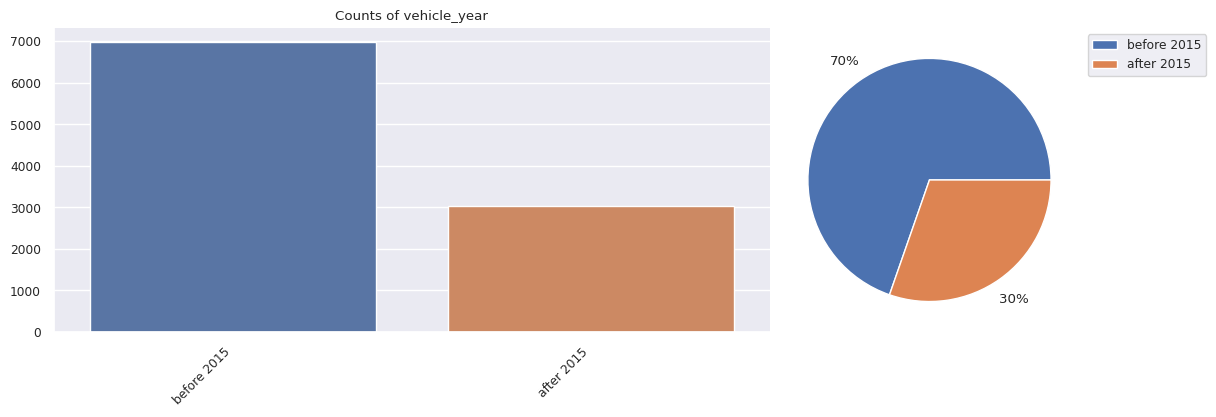

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  postal_code: catgorical column - Nulls: 0(0.0%) - object - 4 distinct values
----------------------------------------------------------------------------------------------------
Top 10 Values  Counts  Frequency(%)
        10238    6940         69.40
        32765    2456         24.56
        92101     484          4.84
        21217     120          1.20
                                                                                
Alerts for feature 'postal_code':
- [!] Warning: Class imbalance detected within column 'postal_code'
- Most common value: '10238' occurs 6940 times (69.4%)
- Not constant or quasi-constant(threshold at 98%).
                                                                                


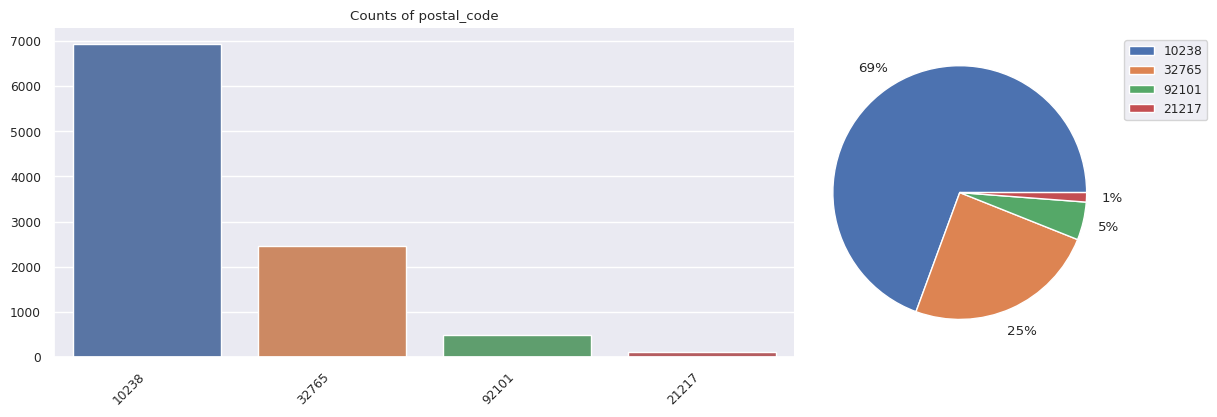

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  vehicle_type: catgorical column - Nulls: 0(0.0%) - object - 2 distinct values
----------------------------------------------------------------------------------------------------
Top 10 Values  Counts  Frequency(%)
        sedan    9523         95.23
   sports car     477          4.77
                                                                                
Alerts for feature 'vehicle_type':
- [!] Warning: Class imbalance detected within column 'vehicle_type'
- Most common value: 'sedan' occurs 9523 times (95.23%)
- Not constant or quasi-constant(threshold at 98%).
                                                                                


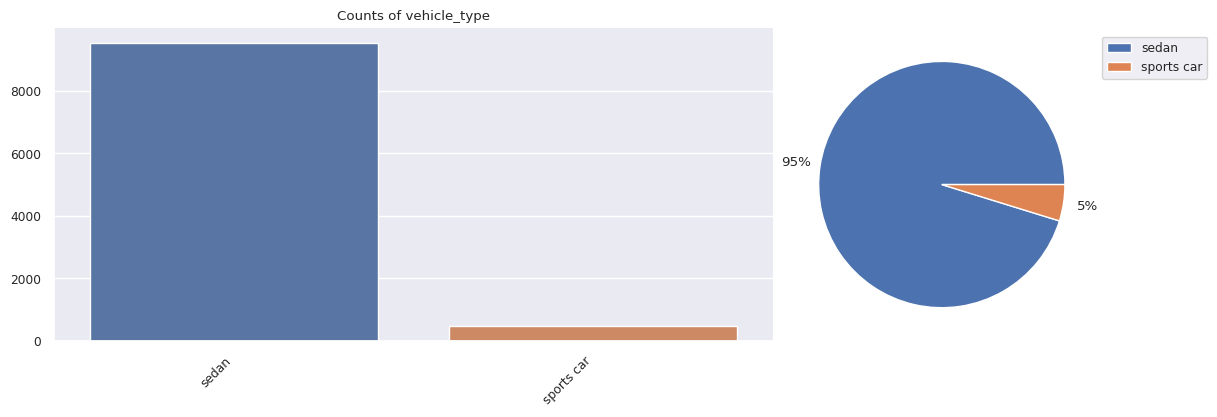

                                                                                
                                                                                
-------------------------------------------------- END - EXPLORE CATEGORICAL --------------------------------------------------


In [61]:
categorical_univariations(df)

------------------------------
- If (p-value <= sig_level) then Null hypothesis is rejected and correspondant features are associated at a level of Cramer's V!
-  Cramer's V varies between [0,1] inclusive.
-  [!] IMPORTANT: Only associated features are plotted
------------------------------


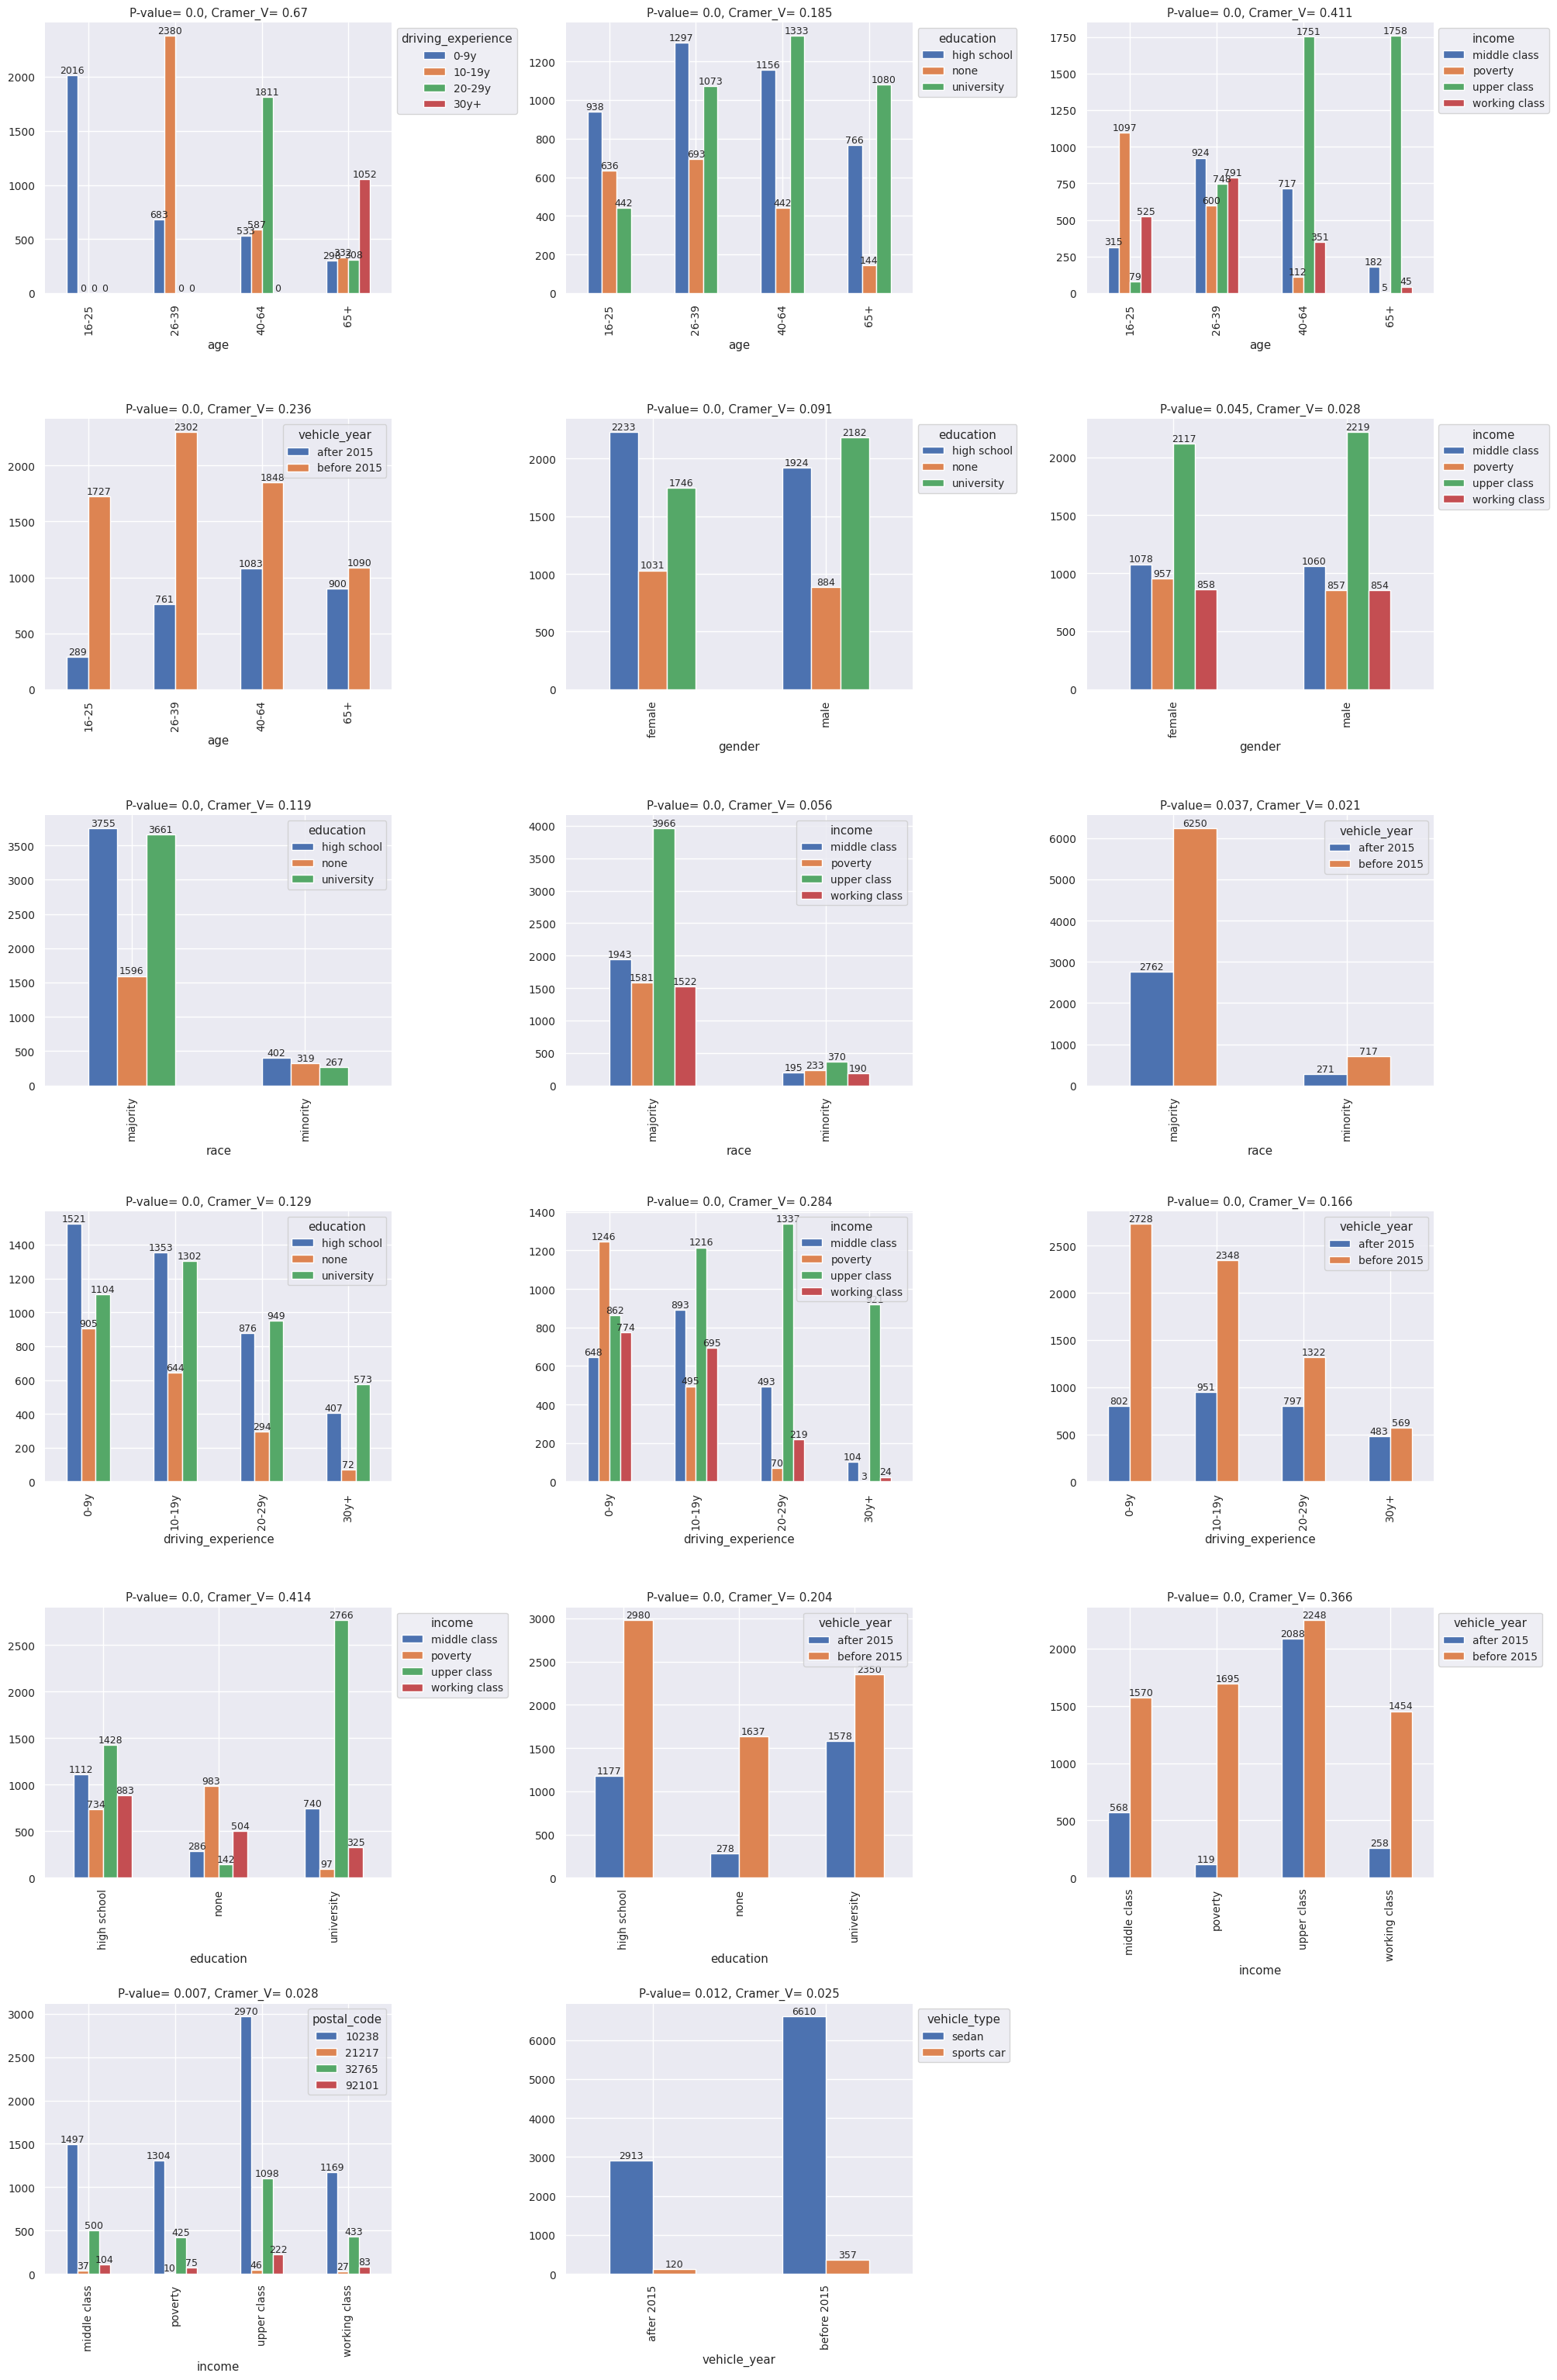

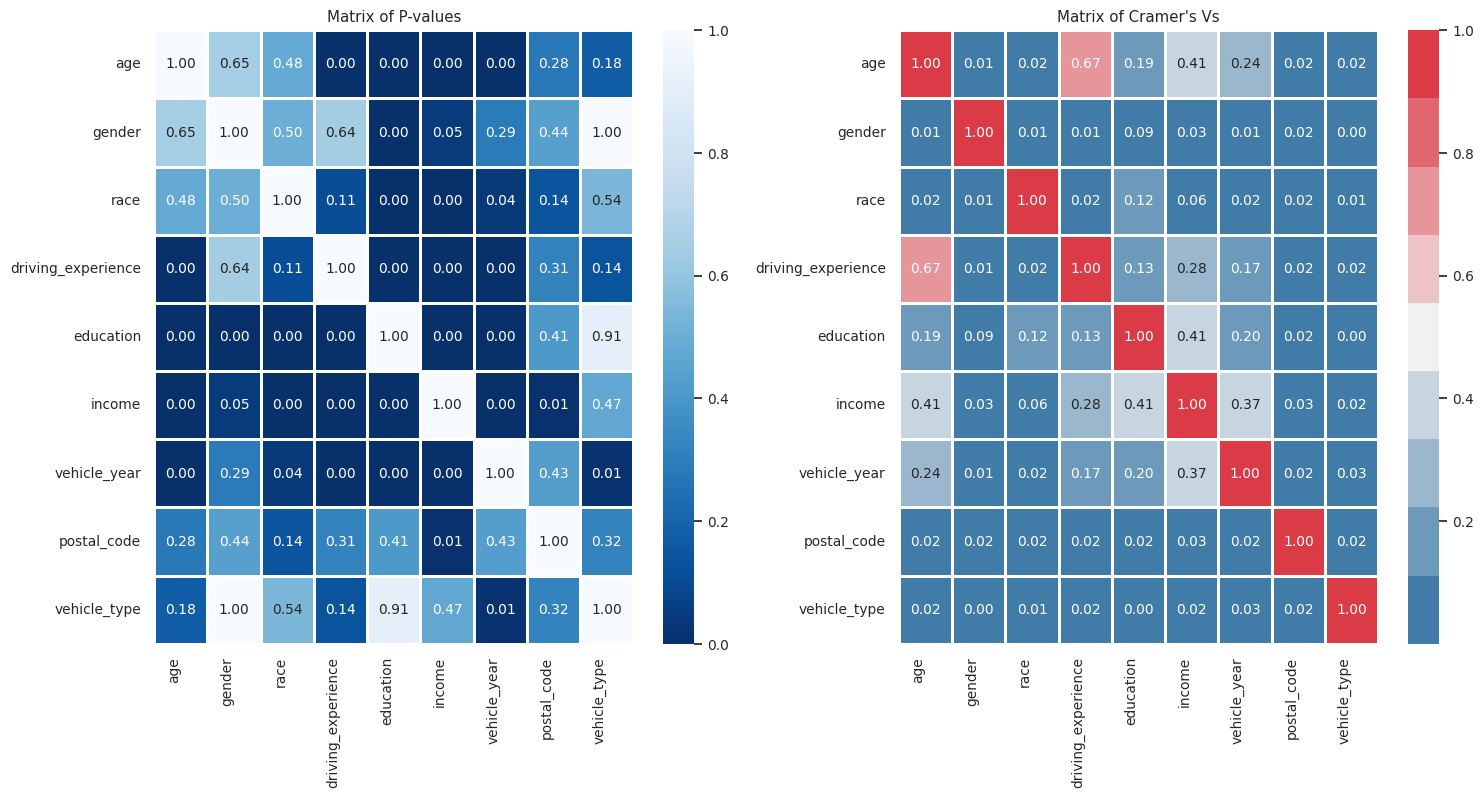

------------------------------------------------------------------------------------------------------------------------
Distributions of the target per columns' categories:


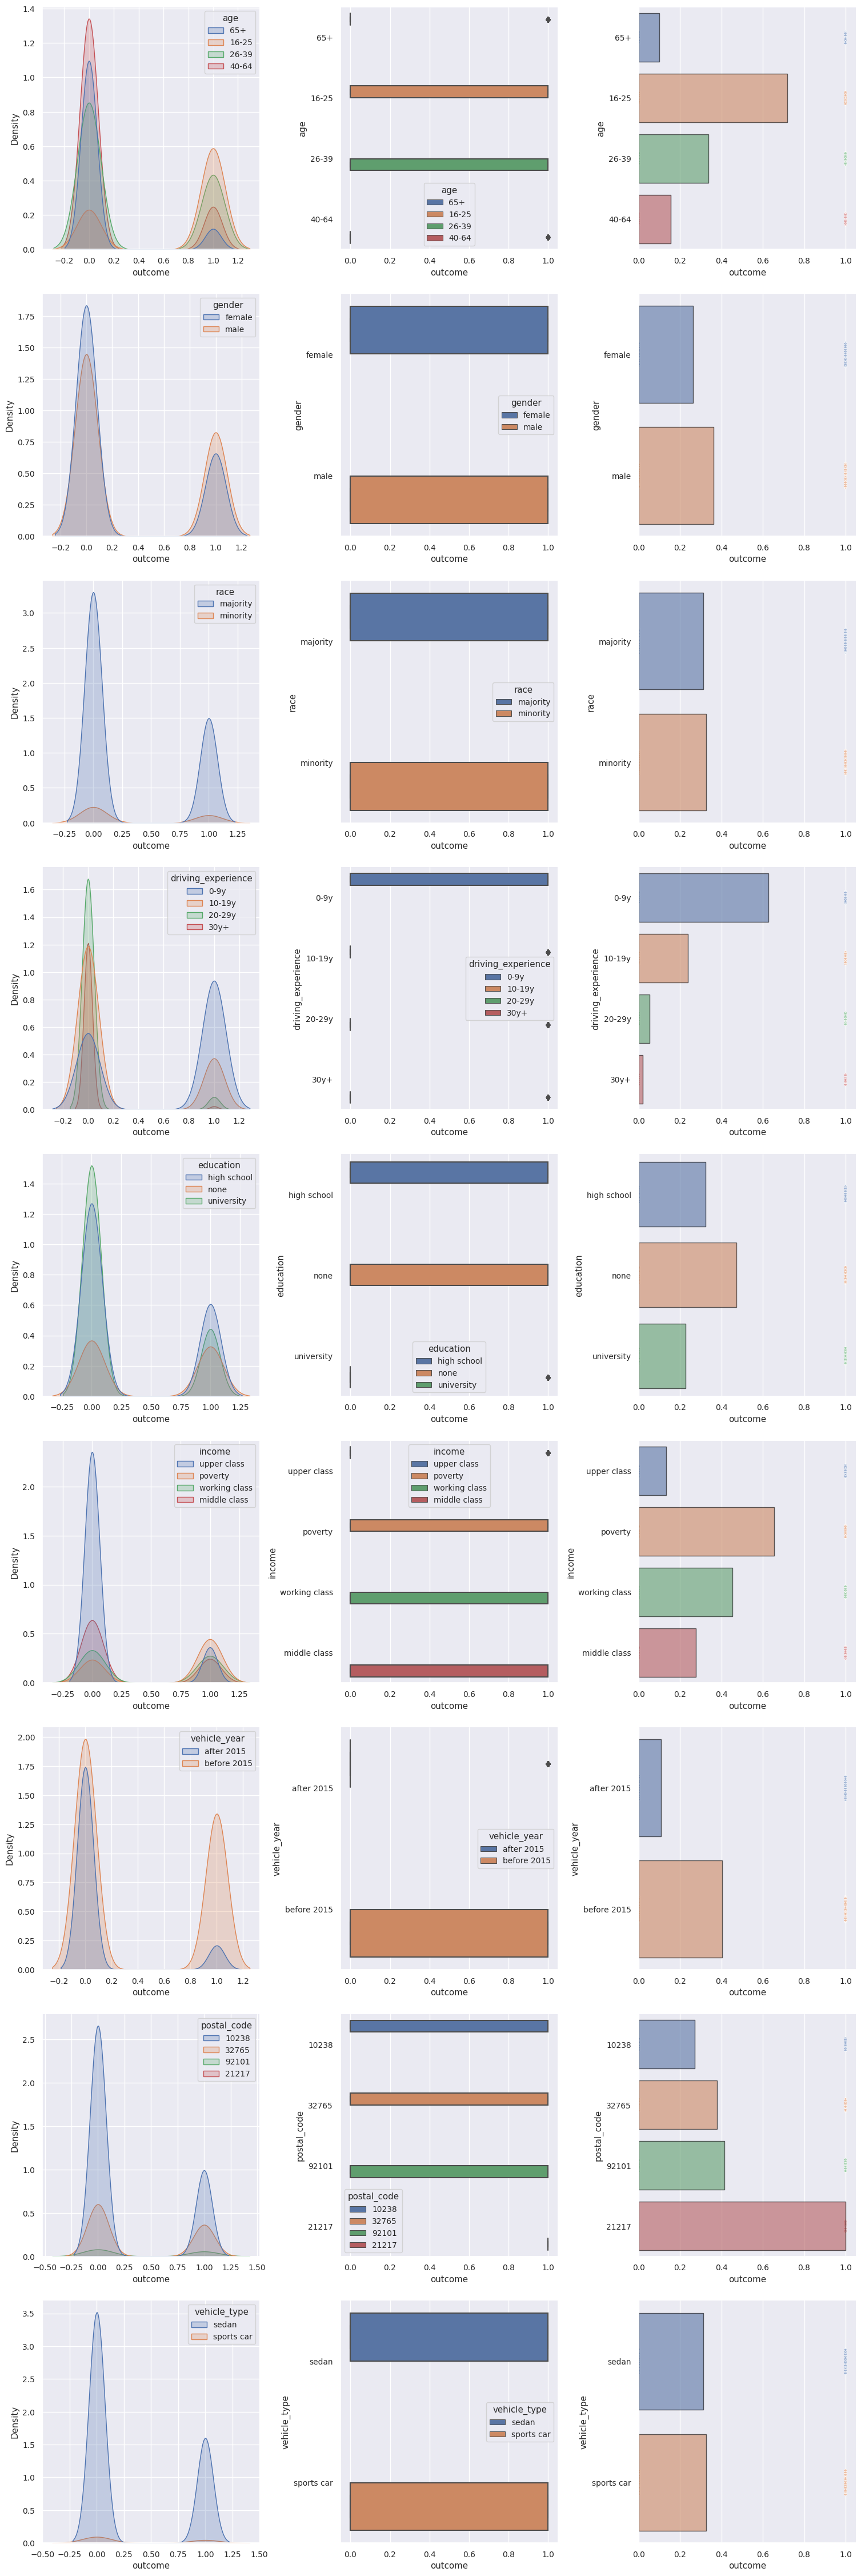

------------------------------------------------------------ END - EXPLORE CATEGORICAL ------------------------------------------------------------


In [65]:
categorical_correlations(df,plot_contingency=True,target='outcome')

##**Observations and Insights:**

- **Outcome** is negatively associated with the number of **past accidents**. **Customers who `did not claim their loans have no past accidents**.
- **The more speeding violations a customer have, the more `accidents` and `DUIs` he commits.** These are **unattentioned** drivers. In fact, more experienced drivers with **more `annual mileage`**, more stable martial status(married with children) are **more vigilent and commits less `speeding violations`**. In the same context, 9-year driving experienced cutomers and above are very less probable to claim their loans. The threshold of 9 years is obvious within the dataset.
- **More than 95% of drivers do not have DUIS.**
- **Young customers** (less than 26 years old) **claims more often** their loans.
- **Customer owning vehicules are less** probable to **claim their loans**, have **higher credit scores** and belong to the **upper class category**.
- **Gender has no effect**.
- **Postal Code and Race depite being very unbalanced do not have any impact on the outcome nor on any other feature.**